<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; color: white; padding: 30px 30px 0px 30px;" align="center">Design an application for public health - Project 3</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h2 style="width: 100%; text-align: center; color: white; float: left;" align="center">| Analysis notebook |</h2>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h3 style="width: 100%; text-align: center; color: white; font-size:26px; float: left;" align="center">Data Scientist course - OpenClassrooms</h3>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
import os
import io
import gc
import itertools
import math
from math import prod
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from functions import *

%matplotlib inline
sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h4>
</div>

In [2]:
def df_analysis(df, name_df, columns, *args, **kwargs):
    """
    Method used for analyzing on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        columns (list): Dataframe keys in list format
        
        *args, **kwargs:
        -----------------
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    flag = kwargs.get("flag", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
            print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        pd.set_option("display.max_rows", None) # show full of showing rows
        pd.set_option("display.max_columns", None) # show full of showing cols
        pd.set_option("max_colwidth", None) # show full width of showing cols
        
        if flag is None or flag != "complete":
            print("\n- Type object and records by columns   (",memory_usage,")")
            print("--------------------------------------------------------------------")
        elif flag == "complete":
            df_resume["unique"] = list(df.nunique())
            df_desc = pd.DataFrame(df.describe().T).reset_index()
            df_desc = df_desc.rename(columns={"index": "name"})
            df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
            df_resume = df_resume[ORDERING_COMPLETE]
            print("\n- Type object and records by columns                                                                   (",memory_usage,")")
            print("---------------------------------------------------------------------------------------------------------------------------------")
        
        display(df_resume.sort_values("records", ascending=False))
        
        pd.reset_option("display.max_rows") # reset max of showing rows
        pd.reset_option("display.max_columns") # reset max of showing cols
        pd.reset_option("display.max_colwidth") # reset width of showing cols
        
        # deleting dataframe to free memory
        if flag == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()
                
        
def normality_test(df):
    """
    Method used for make the normality test.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    list_test = {
        "Shapiro-Wilk":stats.shapiro, "D’Agostino’s K^2":stats.normaltest,
        "Kolmogorov-Smirnov":stats.kstest
    }
    
    
    alpha = 0.05
    fail_to_reject_H = "Sample looks Gaussian (fail to reject H0)"
    reject_H = "Sample does not look Gaussian (reject H0)"
    
    
    
    variable, test_name, result, hypothesis = [[] for i in range(4)]
    
    for key, value in list_test.items():
    
        for col in df.columns:
            
            if df[col].dtypes == "float64":
                variable.append(col)
                test_name.append(key)
                
                if key == "Kolmogorov-Smirnov":
                    stat, p_value = value(df[col], cdf="norm")
                else:
                    stat, p_value = value(df[col])
                    
                result.append("Statistics=%.3f, p-value=%.3f" % (stat, p_value))
                hypothesis.append(fail_to_reject_H.translate(SUB)) if p_value > alpha else hypothesis.append(reject_H.translate(SUB))
                
    df_normality_test = pd.DataFrame({
                            "variable": variable,
                            "normality test": test_name, 
                            "result": result,
                            "hypothesis": hypothesis})

    display(df_normality_test)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h4>
</div>

In [3]:
df_products = pd.read_csv("datasets\dataset_to_analyse.csv")

In [4]:
df_products.head(5)

,code,last_modified_datetime,product_name,categories,main_category,renamed_category,image_url,nutriscore_grade,energy-kcal_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,nutriscore_score
0,0000000005166,2019-02-12 18:38:12,cuisse de poulet direct au four curry,"Viandes, Volailles, Poulets, Cuisses de poulet",en:chicken-thighs,Meats,https://static.openfoodfacts.org/images/produc...,c,197.000000,13.0,3.000000,4.0,0.90000,17.0,1.100000,4.000000
1,0000069163036,2019-02-12 18:38:13,Cuisses de poulet,"Viandes, Volailles, Poulets, Cuisses de poulet",en:chicken-thighs,Meats,https://static.openfoodfacts.org/images/produc...,c,206.000000,15.0,1.700000,4.2,1.70000,16.0,1.100000,5.000000
2,0000130008136,2019-01-04 20:45:08,Escalope de dinde,"Viandes, Volailles, Dindes, Escalopes de dinde",en:turkey-cutlets,Meats,NaN,NaN,151.921668,5.8,0.203145,1.4,0.21262,24.0,1.555556,3.666667
3,00003001,2020-10-28 15:20:28,Filet de poulet extra tendre thym citron,"Viandes, Volailles, Poulets, Filets de poulet",en:chicken-breasts,Meats,https://static.openfoodfacts.org/images/produc...,b,108.000000,1.6,1.600000,0.0,0.70000,22.0,1.300000,1.000000
4,650403,2020-05-04 15:38:15,2 roast chicken legs,"Viandes, Volailles, Poulets, Cuisses de poulet",en:chicken-thighs,Meats,https://static.openfoodfacts.org/images/produc...,b,219.000000,13.4,0.300000,3.4,0.30000,24.4,0.580000,2.000000


In [5]:
df_analysis(df_products, "df_products", "code", flag="complete")


Analysis of df_products dataset
--------------------------------------------------------------------
- Dataset shape:                  16416 rows and 16 columns
- Total of NaN values:            4476
- Percentage of NaN:              1.7 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 2.0+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,16416,16416,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,object,16416,12255,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,categories,object,16416,9,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,main_category,object,16416,9,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,renamed_category,object,16416,6,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,energy-kcal_100g,float64,16416,1253,0,0.00,356.096828,0.0,151.000000,287.00000,510.000000,989.0,253.111215
9,fat_100g,float64,16416,799,0,0.00,26.334906,0.0,5.800000,14.00000,35.000000,100.0,30.046107
10,carbohydrates_100g,float64,16416,901,0,0.00,11.951757,0.0,0.000000,0.50000,2.700000,91.0,22.578130
11,saturated-fat_100g,float64,16416,693,0,0.00,9.366522,0.0,1.400000,3.80000,16.925000,39.0,9.366202
12,sugars_100g,float64,16416,661,0,0.00,6.748045,0.0,0.000000,0.21262,1.200000,67.5,13.077256


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3. Initial analysis</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.1. Nutri Score grade in dataset</h4>
</div>

<div class="alert alert-block alert-info">
    To make the first analysis, we consider <b>all categories of food</b> in the dataset
</div>

In [6]:
data_nutri_score_grade = df_products.copy()

In [7]:
data_piechart = data_nutri_score_grade["nutriscore_grade"].value_counts().values
labels_piechart = ["A", "B", "C", "D", "E"]
textprops = dict(size=16, color="blue", backgroundcolor="white")
colors = dict(A="#058B49", B="#74C928", C="#FBC801", D="#F4730E", E="#EF2D1A")
explode = (0.02, 0, 0, 0, 0)

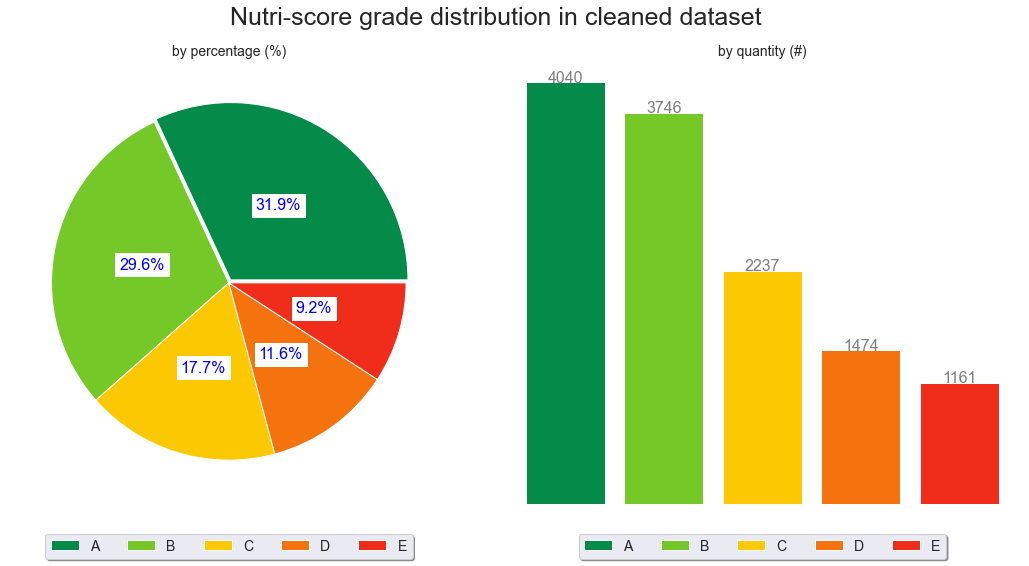

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15,8])

fig.suptitle("Nutri-score grade distribution in cleaned dataset", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors.values()):
    ax2.bar(lb, data, label=lb, color=color)
ax2.legend(loc="upper center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)    
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=0.5, 
        textprops=textprops, colors=[colors[key] for key in labels_piechart], startangle=0)
ax1.legend(labels_piechart, loc="upper center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)
ax1.set_title("by percentage (%)", fontsize=14)

plt.tight_layout()
plt.savefig("img/nutri-score-distribution.png")
plt.show()

<div class="alert alert-block alert-success">
 <b>Observations / Conclusions in cleaned dataset</b>
    <ul style="list-style-type: square;">
        <li><b>Pie chart</b> (by percentage %)</li>
        <ul style="list-style-type: disc;">
           <li>Most of the product <b>(61.5%)</b> are <b>classified</b> between <b>grade A</b> and <b>grade B.</b></li>
           <li>Only the <b>20,8%</b> is <b>classified</b> between <b>grade D</b> and <b>grade E.</b></li>
        </ul>
        <li><b>Bar chart</b> (by quantity %)</li>
        <ul style="list-style-type: disc;">
           <li><b>7786</b> products are classified between <b>grade A</b> and <b>grade B.</b></li>
           <li><b>2635</b> products are classified between <b>grade D</b> and <b>grade E.</b></li>
        </ul>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2. Comparison of the variables in each category</h4>
</div>

<div class="alert alert-block alert-info">
    To limit the analysis to be performed, we are going to work following the next premises
    <ul style="list-style-type: square;">
        <li>Select only <b>4 variables</b> independent to work</li>
        <ul style="list-style-type: disc;">
            <li>energy-kcal_100g</li>
            <li>proteins_100g</li>
            <li>fat_100g</li>
            <li>sugars_100g</li>
        </ul>
    </ul>
</div>

In [9]:
VARIABLES = {
    "energy-kcal_100g":"Energy", "proteins_100g":"Proteins", "fat_100g":"Fat", "sugars_100g":"Sugars", "nutriscore_score":"Nutri-Score"
}

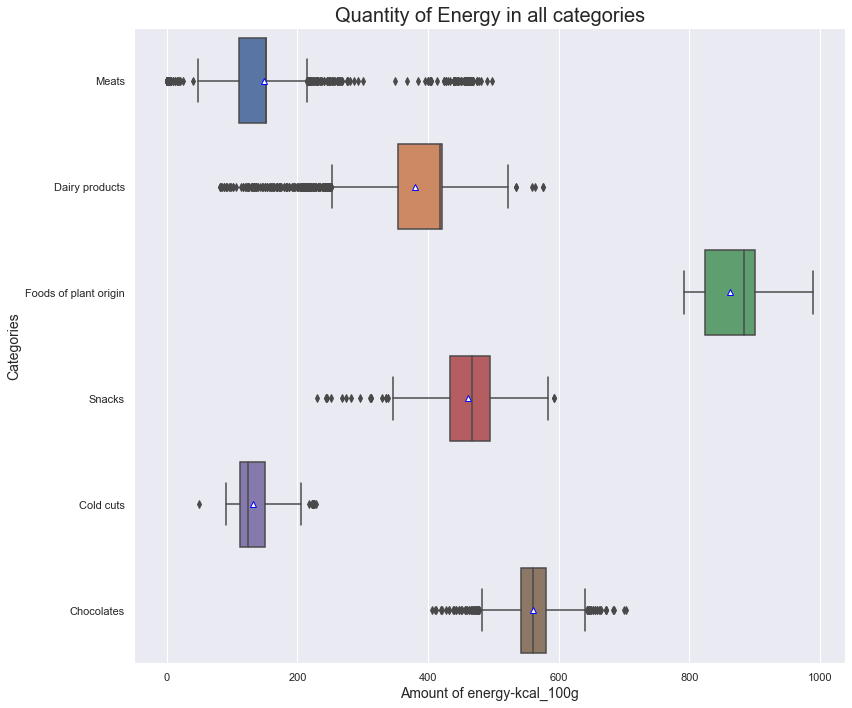

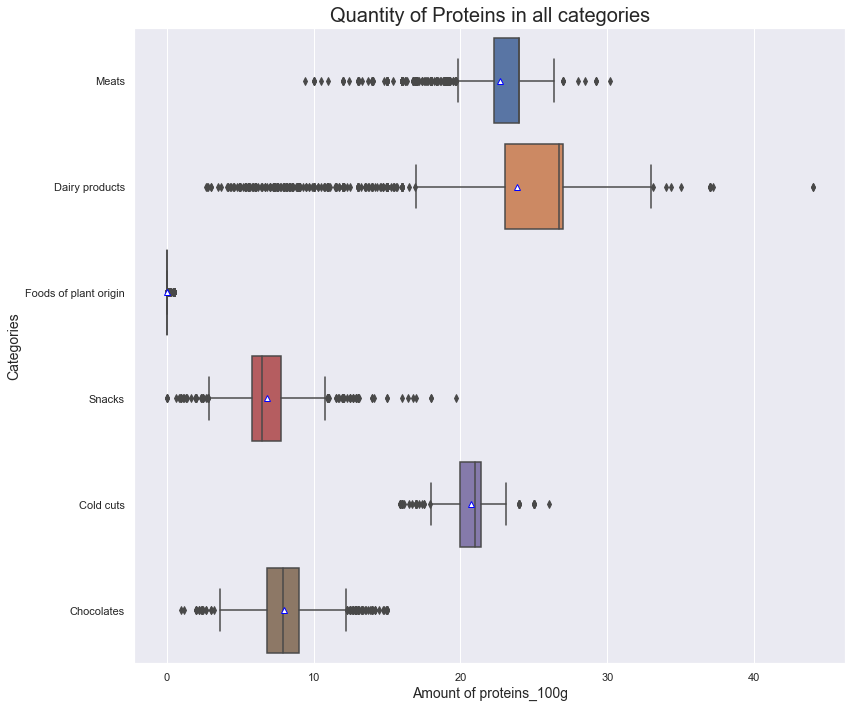

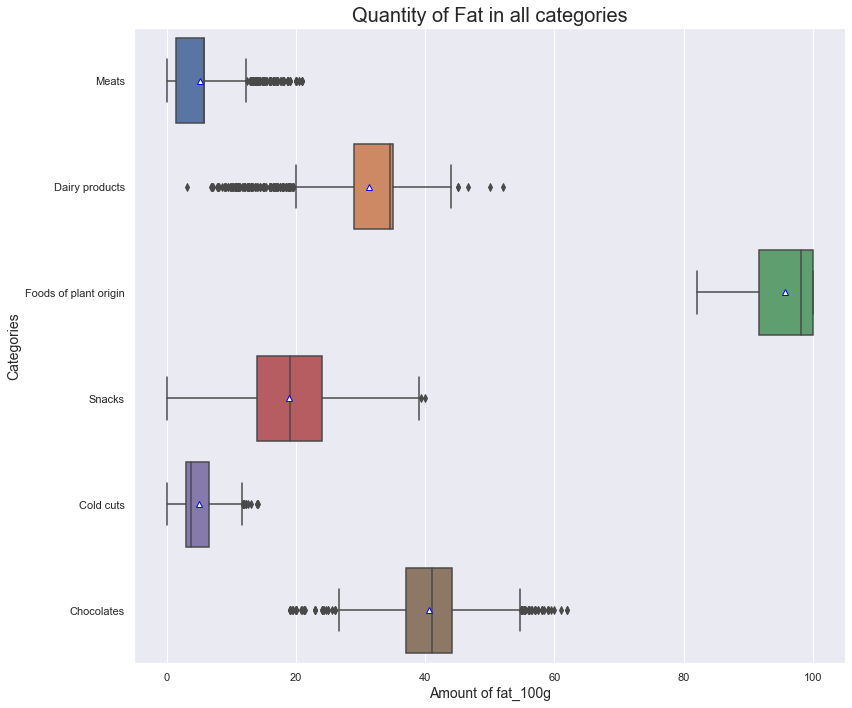

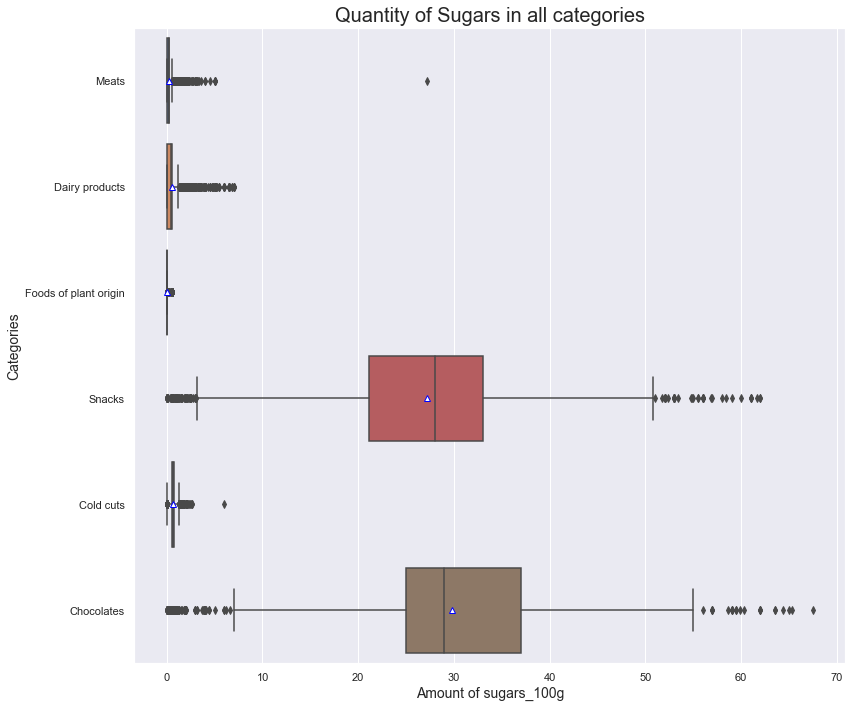

In [10]:
for var in VARIABLES:
    if var != "nutriscore_score":
        plt.figure(figsize=[12,10])
        sns.boxplot(x=df_products[var], y=df_products["renamed_category"], orient="h", showmeans=True, 
                    meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        plt.title("Quantity of " + VARIABLES.get(var) + " in all categories", size=20)
        plt.ylabel("Categories", size=14)
        plt.xlabel("Amount of " + var, size=14)
        plt.tight_layout()
        plt.savefig("img/comparison-of-" + VARIABLES.get(var) + "-in-each-category.png")
        plt.show()

<div class="alert alert-block alert-success">
 <b>Observations / Conclusions related to boxplot</b></br>
 The results are as expected
    <ul style="list-style-type: square;">
        <li>The product categories that offer the most <b>Energy</b> are <b>Food of plant origin</b> and <b>Chocolates</b></li>
        <li><b>Meats</b> and <b>Dairy products</b> (milk, cheese, etc.) offer more <b>Energy</b> compared to the other categories</li>
        <li><b>Food of plant origin</b> and <b>Chocolates</b> offer more <b>Fat</b> compared to the others categories. Probably due to the <b>oils</b> </li>
        <li><b>Snacks</b> and <b>Chocolates</b> offer more <b>Sugar</b> compared to the others categories.</li>
    </ul>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4. Univariate analysis</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.1. Select a subset of data</h4>
</div>

<div class="alert alert-block alert-info">
    To limit the analysis to be performed, we are going to work with:
    
    <ul style="list-style-type: square;">
        <li><b>3</b> categories</li>
        <li><b>3 independent</b> variables </li>
        <ul style="list-style-type: disc;">
            <li>energy-kcal_100g (independent)</li>
            <li>proteins_100g (independent)</li>
            <li>sugars_100g (independent)</li>
        </ul>
    </ul>
</div>

In [11]:
VARIABLES = {
    "energy-kcal_100g":"Energy", "proteins_100g":"Proteins", "sugars_100g":"Sugars", "nutriscore_score":"Nutri-Score"
}

In [12]:
df_products.groupby("renamed_category")["code"].count().sort_values(ascending=False)

renamed_category
Meats                    6141
Dairy products           2469
Foods of plant origin    2125
Snacks                   1936
Cold cuts                1934
Chocolates               1811
Name: code, dtype: int64

<div class="alert alert-block alert-info">
    Filtering the dataset based on the <b>3 categories</b> selected
</div>

In [13]:
df_subset = df_products[df_products["renamed_category"].isin(["Meats", "Dairy products", "Snacks"])].copy()

In [14]:
df_subset.shape

(10546, 16)

<div class="alert alert-block alert-info">
    <b>Filtering</b> the necessary columns
</div>

In [15]:
df_temp = df_subset[["renamed_category"] + [key for key, values in VARIABLES.items()]].copy()

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.2. Variables distribution and Quantile-Quantile Plot in Meats</h4>
</div>

<div class="alert alert-block alert-info">
    <b>Plotting</b> the variables distribution for each <b>Meats</b>
</div>

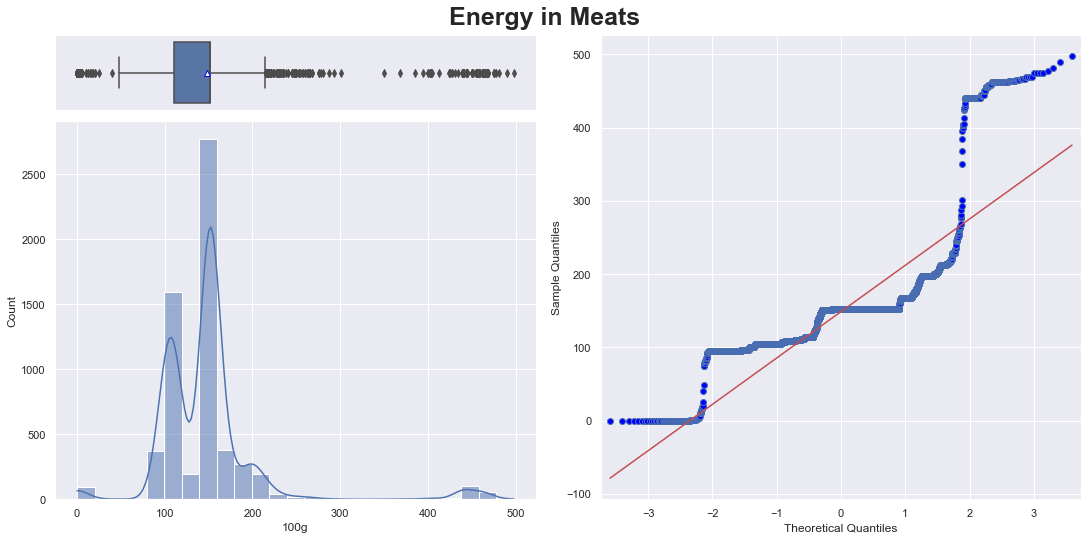

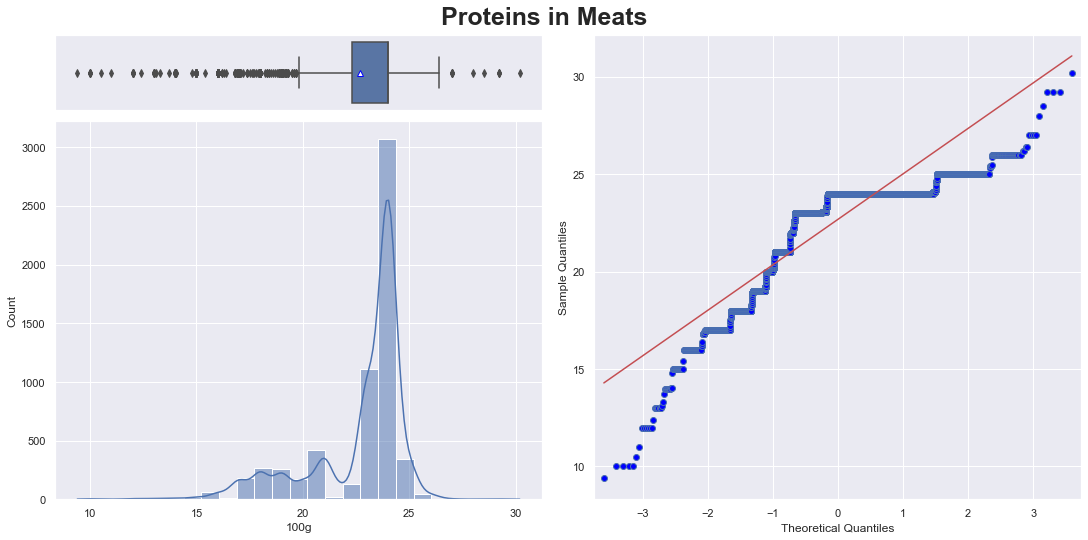

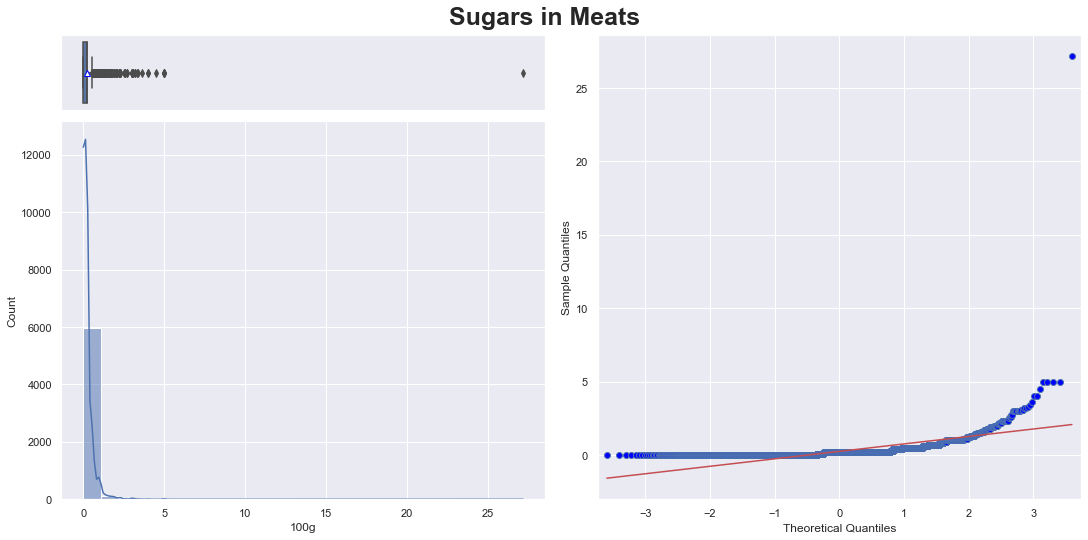

In [16]:
df_temp_by_cat = df_temp[df_temp["renamed_category"] == "Meats"].copy()

for key, value in VARIABLES.items():

    if value != "Nutri-Score":

        fig = plt.figure(constrained_layout=True, figsize=[15,7])
        fig.suptitle(value + " in " + "Meats", size=25, fontweight="bold", y=1.05)
        spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

        ax_box = fig.add_subplot(spec[0, 0])
        ax_hist = fig.add_subplot(spec[1, 0])
        ax_qqplot = fig.add_subplot(spec[:, 1])

        # Boxplot
        boxplot = sns.boxplot(data=df_temp_by_cat, x=df_temp_by_cat[key], showmeans=True, ax=ax_box,
                              meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        ax_box.set(xlabel="", xticks=[])
        ax_box.set(yticks=[])
        boxplot.set_title("")

        # Histplot
        sns.histplot(data=df_temp_by_cat, x=df_temp_by_cat[key], bins=25,  kde=True,  ax=ax_hist)
        ax_hist.set(xlabel="100g")

        # QQplot
        qqplot(df_temp_by_cat[key], line='s', ax=ax_qqplot)

        plt.savefig("img/qqplot-of-" + value + "-in-" + "Meats" + ".png")

<div class="alert alert-block alert-success">
 <b>Observations / Conclusions variables in Meats</b></br>
    <ul style="list-style-type: square;">
        <li><b>Energy</b> has a <b>bimodal distribution</b>. Probably due to the different types of meat (red and white) selected at the cleaning moment</li>
        <li><b>Proteins</b> has a distribution <b>spread on the left</b></li>
        <li><b>Sugars</b> has a distribution <b>spread on the right</b></li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">4.2.1 Normality test in Meats</h5>
</div>

<div class="alert alert-block alert-info">
    <b>$H_{0}$</b> - For all of variables, we are going to assume that the sample was drawn from a <b>"Gaussian distribution"</b>
</div>

In [17]:
print("\nCategory: (", "".join(df_temp_by_cat["renamed_category"].unique()), ")")
print("---------------------------------------------------------------------------------------------")
normality_test(df_temp_by_cat[[key for key, values in VARIABLES.items() if key != "nutriscore_score"]])


Category: ( Meats )
---------------------------------------------------------------------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,energy-kcal_100g,Shapiro-Wilk,"Statistics=0.652, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,proteins_100g,Shapiro-Wilk,"Statistics=0.751, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,sugars_100g,Shapiro-Wilk,"Statistics=0.355, p-value=0.000",Sample does not look Gaussian (reject H₀)
3,energy-kcal_100g,D’Agostino’s K^2,"Statistics=3972.270, p-value=0.000",Sample does not look Gaussian (reject H₀)
4,proteins_100g,D’Agostino’s K^2,"Statistics=1823.949, p-value=0.000",Sample does not look Gaussian (reject H₀)
5,sugars_100g,D’Agostino’s K^2,"Statistics=15203.159, p-value=0.000",Sample does not look Gaussian (reject H₀)
6,energy-kcal_100g,Kolmogorov-Smirnov,"Statistics=0.987, p-value=0.000",Sample does not look Gaussian (reject H₀)
7,proteins_100g,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)
8,sugars_100g,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


<div class="alert alert-block alert-success">
    <b>Observations / Conclusions of normality test of variables in Meats</b>
 
    <ul style="list-style-type: square;">
        <li><b>Shapiro-Wilk</b> shows a warning due to <b>N > 5000</b>. Due to that, we aren't consider that test in the category</li>
        <li>Based on the <b>D’Agostino’s $K^{2}$</b> and <b>Kolmogorov-Smirnov</b> no variable has a normal distribution</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.3. Variables distribution and Quantile-Quantile Plot in Dairy products</h4>
</div>

<div class="alert alert-block alert-info">
    <b>Plotting</b> the variables distribution for each <b>Dairy products</b>
</div>

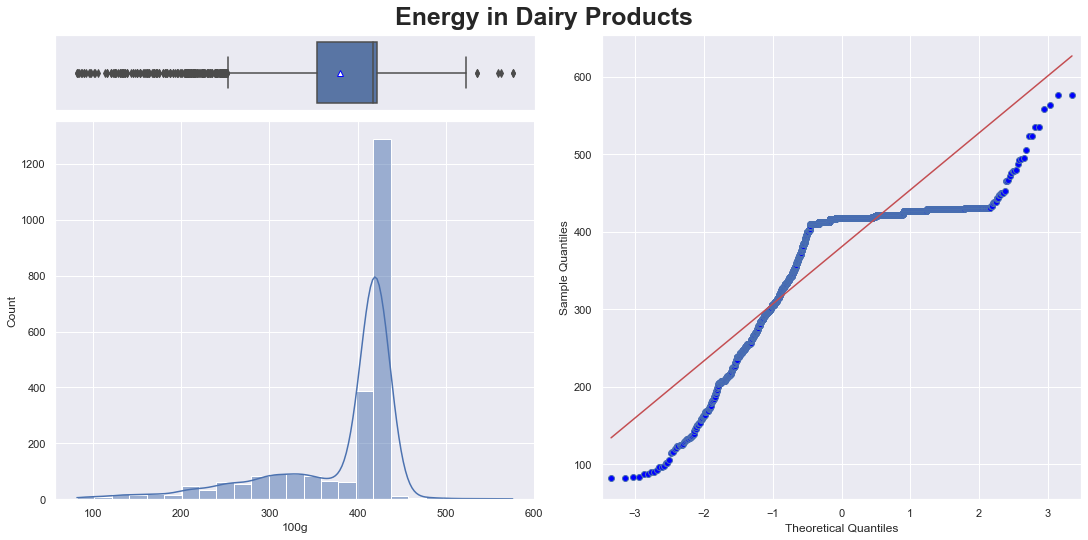

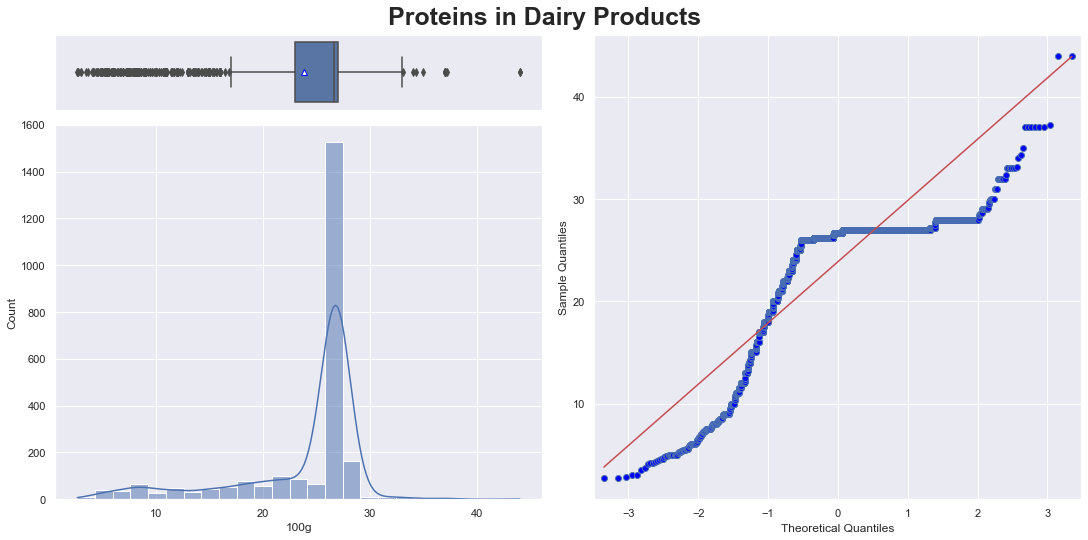

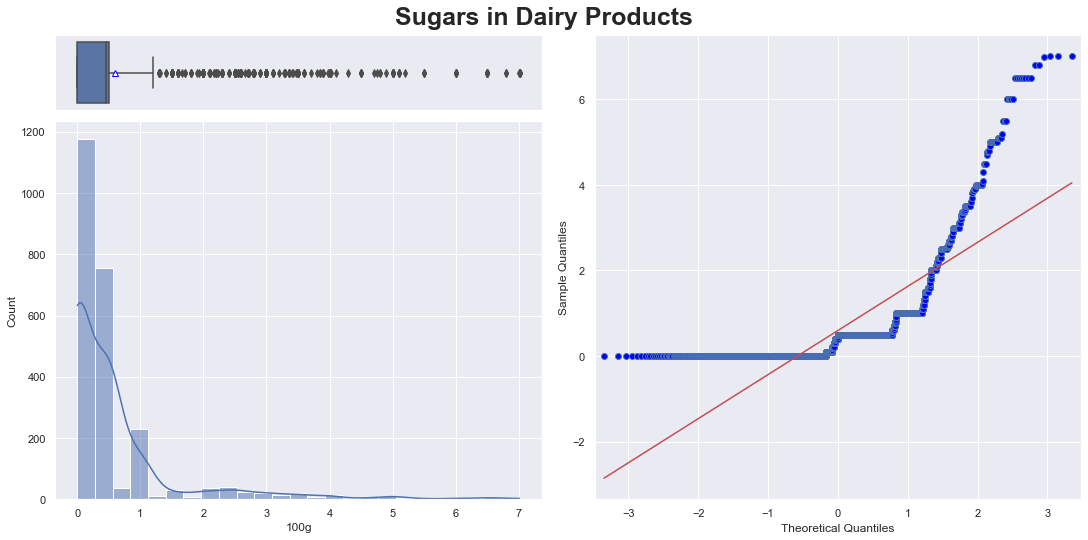

In [18]:
df_temp_by_cat = df_temp[df_temp["renamed_category"] == "Dairy products"].copy()

for key, value in VARIABLES.items():

    if value != "Nutri-Score":

        fig = plt.figure(constrained_layout=True, figsize=[15,7])
        fig.suptitle(value + " in " + "Dairy Products", size=25, fontweight="bold", y=1.05)
        spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

        ax_box = fig.add_subplot(spec[0, 0])
        ax_hist = fig.add_subplot(spec[1, 0])
        ax_qqplot = fig.add_subplot(spec[:, 1])

        # Boxplot
        boxplot = sns.boxplot(data=df_temp_by_cat, x=df_temp_by_cat[key], showmeans=True, ax=ax_box,
                              meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        ax_box.set(xlabel="", xticks=[])
        ax_box.set(yticks=[])
        boxplot.set_title("")

        # Histplot
        sns.histplot(data=df_temp_by_cat, x=df_temp_by_cat[key], bins=25,  kde=True,  ax=ax_hist)
        ax_hist.set(xlabel="100g")

        # QQplot
        qqplot(df_temp_by_cat[key], line='s', ax=ax_qqplot)
        
        plt.savefig("img/qqplot-of-" + value + "-in-" + "Dairy Products" + ".png")
        

<div class="alert alert-block alert-success">
 <b>Observations / Conclusions variables in Dairy products</b></br>
    <ul style="list-style-type: square;">
        <li><b>Energy</b> has a distribution <b>spread on the left</b></li>
        <li><b>Proteins</b> has a distribution <b>spread on the left</b></li>
        <li><b>Sugars</b> has a distribution <b>spread on the right</b></li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">4.3.1 Normality test in Dairy products</h5>
</div>

<div class="alert alert-block alert-info">
    <b>$H_{0}$</b> - For all of variables, we are going to assume that the sample was drawn from a <b>"Gaussian distribution"</b>
</div>

In [19]:
print("\nCategory: (", "".join(df_temp_by_cat["renamed_category"].unique()), ")")
print("---------------------------------------------------------------------------------------------")
normality_test(df_temp_by_cat[[key for key, values in VARIABLES.items() if key != "nutriscore_score"]])


Category: ( Dairy products )
---------------------------------------------------------------------------------------------


,variable,normality test,result,hypothesis
0,energy-kcal_100g,Shapiro-Wilk,"Statistics=0.720, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,proteins_100g,Shapiro-Wilk,"Statistics=0.699, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,sugars_100g,Shapiro-Wilk,"Statistics=0.592, p-value=0.000",Sample does not look Gaussian (reject H₀)
3,energy-kcal_100g,D’Agostino’s K^2,"Statistics=780.294, p-value=0.000",Sample does not look Gaussian (reject H₀)
4,proteins_100g,D’Agostino’s K^2,"Statistics=745.753, p-value=0.000",Sample does not look Gaussian (reject H₀)
5,sugars_100g,D’Agostino’s K^2,"Statistics=1647.639, p-value=0.000",Sample does not look Gaussian (reject H₀)
6,energy-kcal_100g,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)
7,proteins_100g,Kolmogorov-Smirnov,"Statistics=0.998, p-value=0.000",Sample does not look Gaussian (reject H₀)
8,sugars_100g,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


<div class="alert alert-block alert-success">
    <b>Observations / Conclusions of normality test of variables in Meats</b>
 
    <ul style="list-style-type: square;">
        <li>Based on the <b>Shapiro-Wilk</b>, <b>D’Agostino’s $K^{2}$</b> and <b>Kolmogorov-Smirnov</b> no variable has a normal distribution</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.4. Variables distribution and Quantile-Quantile Plot in Snacks</h4>
</div>

<div class="alert alert-block alert-info">
    <b>Plotting</b> the variables distribution for each <b>Snacks</b>
</div>

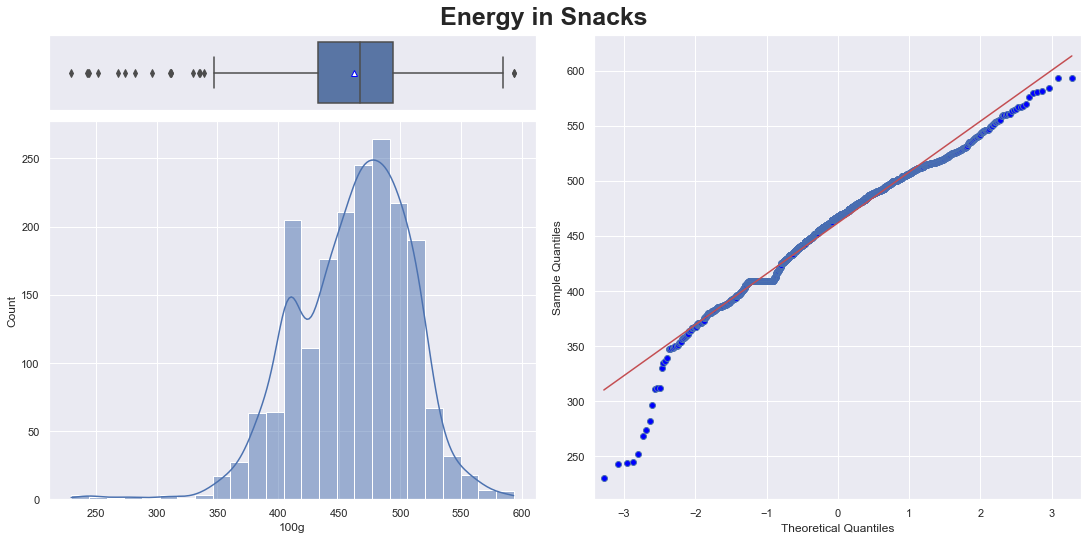

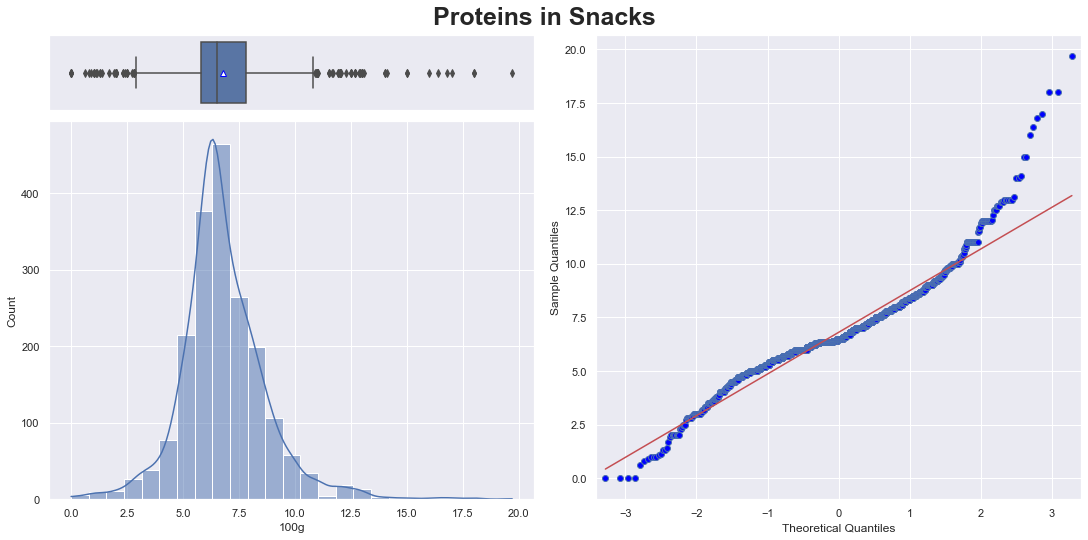

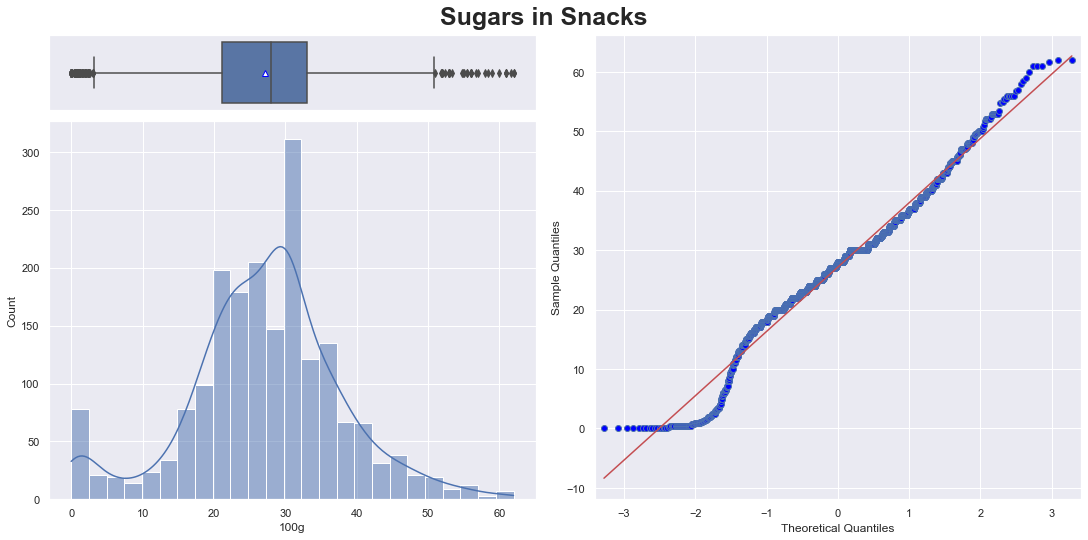

In [20]:
df_temp_by_cat = df_temp[df_temp["renamed_category"] == "Snacks"].copy()

for key, value in VARIABLES.items():

    if value != "Nutri-Score":

        fig = plt.figure(constrained_layout=True, figsize=[15,7])
        fig.suptitle(value + " in " + "Snacks", size=25, fontweight="bold", y=1.05)
        spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

        ax_box = fig.add_subplot(spec[0, 0])
        ax_hist = fig.add_subplot(spec[1, 0])
        ax_qqplot = fig.add_subplot(spec[:, 1])

        # Boxplot
        boxplot = sns.boxplot(data=df_temp_by_cat, x=df_temp_by_cat[key], showmeans=True, ax=ax_box,
                              meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        ax_box.set(xlabel="", xticks=[])
        ax_box.set(yticks=[])
        boxplot.set_title("")

        # Histplot
        sns.histplot(data=df_temp_by_cat, x=df_temp_by_cat[key], bins=25,  kde=True,  ax=ax_hist)
        ax_hist.set(xlabel="100g")

        # QQplot
        qqplot(df_temp_by_cat[key], line='s', ax=ax_qqplot)

        plt.savefig("img/qqplot-of-" + value + "-in-" + "Snacks" + ".png")

<div class="alert alert-block alert-success">
 <b>Observations / Conclusions variables in Snacks</b></br>
    <ul style="list-style-type: square;">
        <li><b>Energy</b> a has <b>almost a normal</b> distribution</li>
        <li><b>Proteins</b> has a <b>normal</b> distribution </li>
        <li><b>Sugars</b> a has <b>almost a normal</b> distribution</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">4.4.1 Normality test in Snacks</h5>
</div>

<div class="alert alert-block alert-info">
    <b>$H_{0}$</b> - For all of variables, we are going to assume that the sample was drawn from a <b>"Gaussian distribution"</b>
</div>

In [21]:
print("\nCategory: (", "".join(df_temp_by_cat["renamed_category"].unique()), ")")
print("---------------------------------------------------------------------------------------------")
normality_test(df_temp_by_cat[[key for key, values in VARIABLES.items() if key != "nutriscore_score"]])


Category: ( Snacks )
---------------------------------------------------------------------------------------------


,variable,normality test,result,hypothesis
0,energy-kcal_100g,Shapiro-Wilk,"Statistics=0.976, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,proteins_100g,Shapiro-Wilk,"Statistics=0.933, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,sugars_100g,Shapiro-Wilk,"Statistics=0.977, p-value=0.000",Sample does not look Gaussian (reject H₀)
3,energy-kcal_100g,D’Agostino’s K^2,"Statistics=142.103, p-value=0.000",Sample does not look Gaussian (reject H₀)
4,proteins_100g,D’Agostino’s K^2,"Statistics=405.612, p-value=0.000",Sample does not look Gaussian (reject H₀)
5,sugars_100g,D’Agostino’s K^2,"Statistics=32.362, p-value=0.000",Sample does not look Gaussian (reject H₀)
6,energy-kcal_100g,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)
7,proteins_100g,Kolmogorov-Smirnov,"Statistics=0.981, p-value=0.000",Sample does not look Gaussian (reject H₀)
8,sugars_100g,Kolmogorov-Smirnov,"Statistics=0.956, p-value=0.000",Sample does not look Gaussian (reject H₀)


<div class="alert alert-block alert-success">
    <b>Observations / Conclusions of normality test of variables in Snacks</b>
 
    <ul style="list-style-type: square;">
        <li>Based on the <b>Shapiro-Wilk</b>, <b>D’Agostino’s $K^{2}$</b> and <b>Kolmogorov-Smirnov</b> no variable has a normal distribution</li>
    </ul>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5. Bivariate analysis</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.1. Select a subset of data</h4>
</div>

<div class="alert alert-block alert-info">
    To limit the analysis to be performed, we are going to work only with <b>1 categories</b>, in this case <b>Snacks</b>
</div>

In [22]:
df_products.groupby("renamed_category")["code"].count().sort_values(ascending=False)

renamed_category
Meats                    6141
Dairy products           2469
Foods of plant origin    2125
Snacks                   1936
Cold cuts                1934
Chocolates               1811
Name: code, dtype: int64

In [23]:
df_subset = df_products[df_products["renamed_category"].isin(["Snacks"])].copy()

In [24]:
df_subset.shape

(1936, 16)

In [25]:
df_analysis(df_subset, "df_subset", "code", flag="complete")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  1936 rows and 16 columns
- Total of NaN values:            264
- Percentage of NaN:              0.85 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 257.1+ KB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,1936,1936,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,object,1936,1902,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,categories,object,1936,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,main_category,object,1936,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,renamed_category,object,1936,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,energy-kcal_100g,float64,1936,414,0,0.00,461.744774,230.00000,432.805544,467.000000,494.150153,593.000000,46.230653
9,fat_100g,float64,1936,327,0,0.00,18.921852,0.00000,14.000000,19.000000,24.000000,40.000000,6.939658
10,carbohydrates_100g,float64,1936,382,0,0.00,64.141583,0.56875,60.000000,65.000000,69.000000,91.000000,8.337608
11,saturated-fat_100g,float64,1936,274,0,0.00,8.728878,0.00000,3.700000,8.000000,13.000000,26.000000,5.646426
12,sugars_100g,float64,1936,411,0,0.00,27.164703,0.00000,21.075000,27.999213,33.000000,62.000000,10.829652


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.2. Pearson correlation</h4>
</div>

<div class="alert alert-block alert-info">
    To limit the analysis to be performed, we are going to work only with <b>1 categories</b>, in this case <b>Snacks</b>
</div>

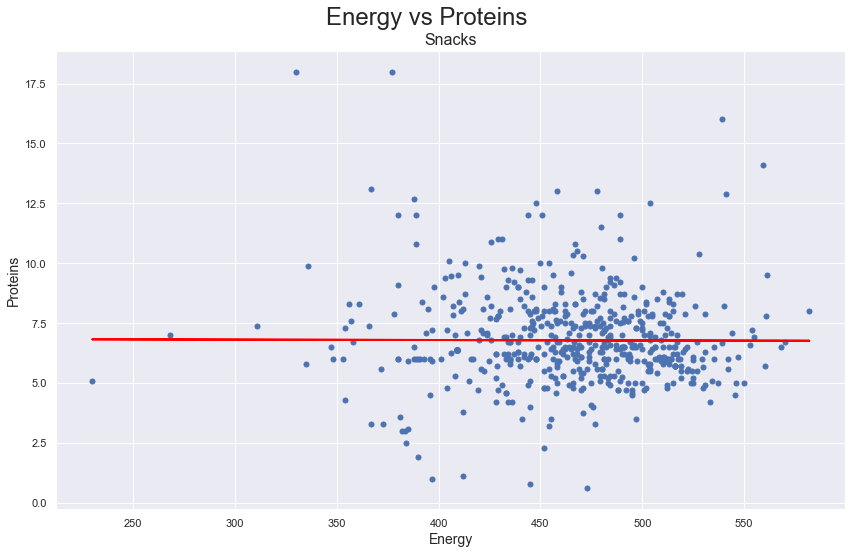

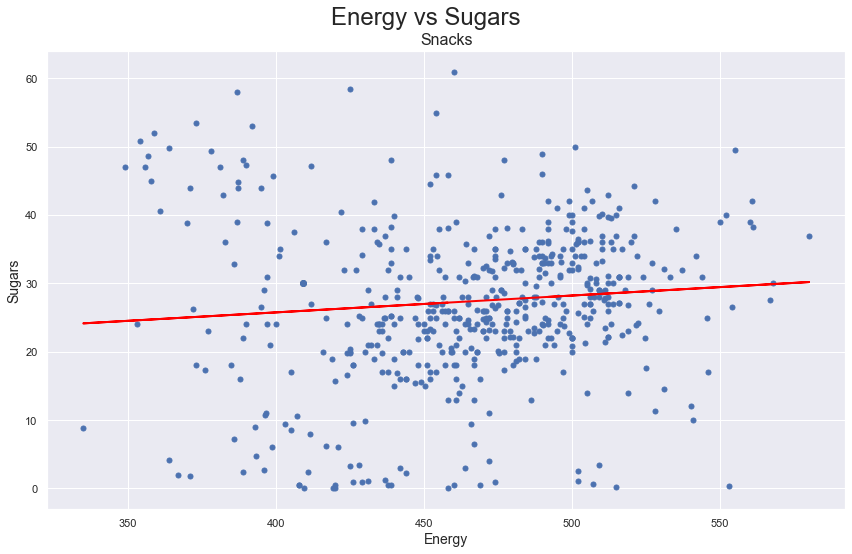

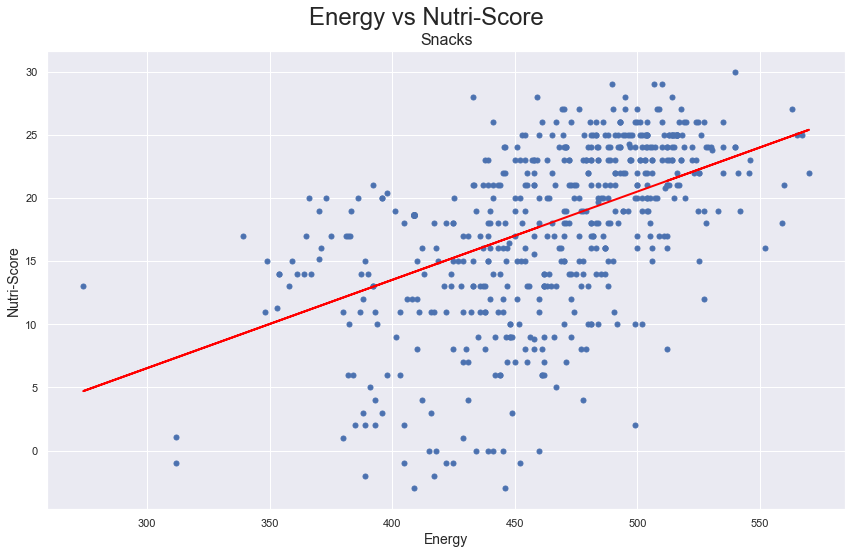

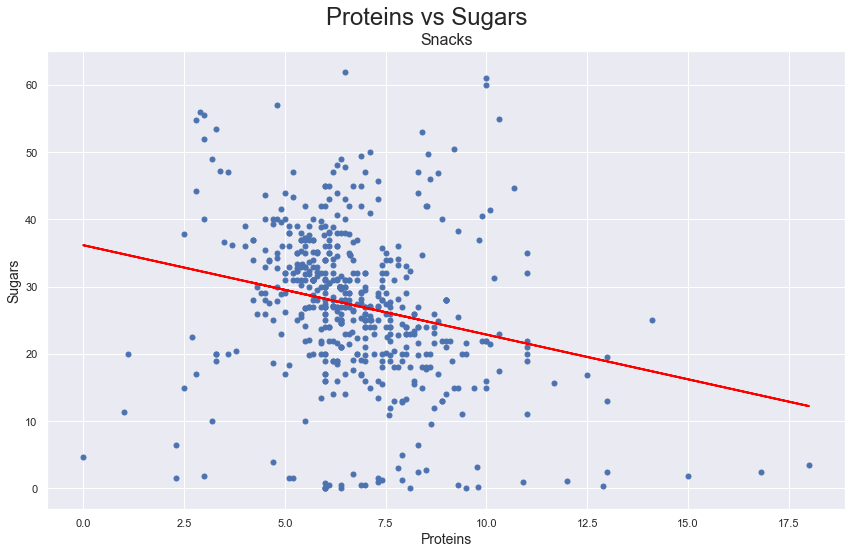

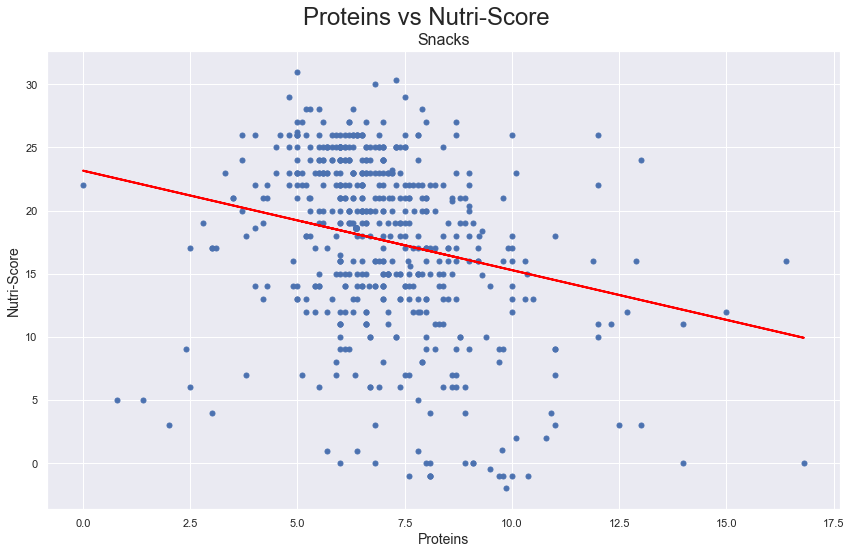

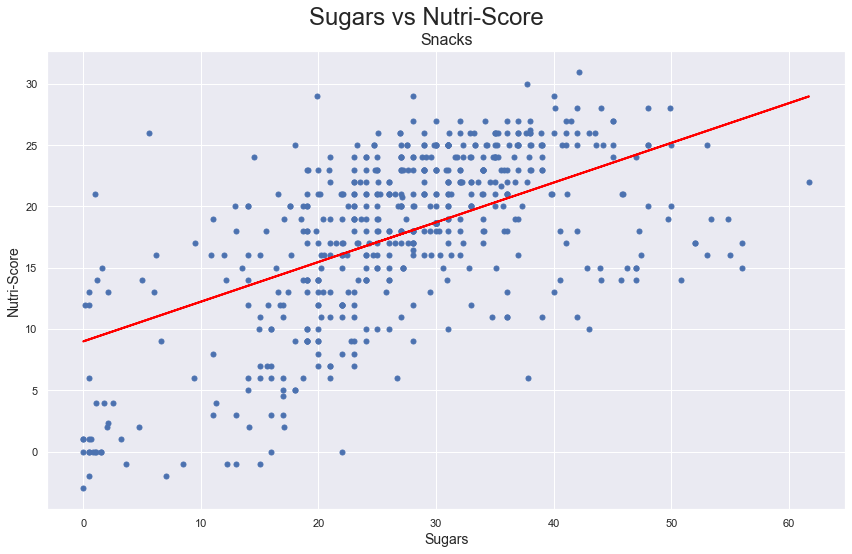

,variables,Coef.,MSE,RMSE,R2SCORE
0,Energy vs Proteins,-0.0002,3.74,1.93,-0.00
1,Energy vs Sugars,0.0247,116.26,10.78,0.00
2,Energy vs Nutri-Score,0.0699,33.49,5.79,0.26
3,Proteins vs Sugars,-1.3296,113.49,10.65,0.08
4,Proteins vs Nutri-Score,-0.7872,41.09,6.41,0.10
5,Sugars vs Nutri-Score,0.3238,29.58,5.44,0.37


In [26]:
list_variables, list_COEF, list_MSE, list_RMSE, list_R2SCORE = ([] for i in range(5))

for a, b in itertools.combinations(VARIABLES, 2):
    
    # initializing Linear Regression by Pearson
    lr = LinearRegression()
    xtrain, xtest, ytrain, ytest = train_test_split(df_subset[[a]], df_subset[[b]], test_size=0.3)
    lr = LinearRegression()
    lr_baseline = lr.fit(xtrain, ytrain)
    pred_baseline = lr_baseline.predict(xtest)
    
    list_variables.append(VARIABLES.get(a) + " vs " + VARIABLES.get(b))
    list_COEF.append(round(lr_baseline.coef_[0,0], 4))
    list_MSE.append(round(mean_squared_error(ytest, pred_baseline), 2))
    list_RMSE.append(round(math.sqrt(mean_squared_error(ytest, pred_baseline)), 2))
    list_R2SCORE.append(round(r2_score(ytest, pred_baseline), 2))
    
    # PLotting the graph
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    
    plt.suptitle(VARIABLES.get(a) + " vs " + VARIABLES.get(b), fontsize=24, y=0.96)
    plt.title("Snacks",fontsize=16)
    plt.plot(xtest, ytest, 'bo', markersize = 5)
    plt.plot(xtest, pred_baseline, color="red", linewidth = 2)
    plt.xlabel(VARIABLES.get(a), size=14)
    plt.ylabel(VARIABLES.get(b), size=14)
    plt.tight_layout()
    plt.savefig("img/correlation-" + VARIABLES.get(a) + "-vs-" + VARIABLES.get(b) + ".png")
    plt.show()
    
df_metrics_bivariate = pd.DataFrame({
    "variables":list_variables,
    "Coef.":list_COEF,
    "MSE":list_MSE,
    "RMSE":list_RMSE,
    "R2SCORE":list_R2SCORE
})
df_metrics_bivariate

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br>
    
    <ul style="list-style-type: square;">
        <li><b>Coefficient</b></li>
        <ul style="list-style-type: disc;">
           <li><b>Proteins vs Sugars</b> have and inverse relationship</li>
           <li><b>Proteins vs Nutri-Score</b> have an inverse relationship</li>
           <li><b>Sugars vs Nutri-Score</b> have a weak direct relationship</li>
           <li><b>Energy vs Nutri-Score</b> don't have a relationship</li>
           <li><b>Energy vs Sugars</b> don't have a relationship</li>
        </ul>
    </ul>
    
    <ul style="list-style-type: square;">
        <li><b>MSE</b></li>
        <ul style="list-style-type: square;">
           <li>The <b>best</b> result are:</li>
           <ul style="list-style-type: circle;">
               <li>Energy vs Proteins: 3.95</li>
               <li>Sugars vs Nutri-Score: 30.85</li>
            </ul>
        </ul>
    </ul>
    
    <ul style="list-style-type: square;">
        <li><b>R² - Score</b><br>As we know, the closer the value of r2 is to 1, the greater the fit of the model to the variable we are trying to explain.</li>
        <ul style="list-style-type: disc;">
           <li>The <b>tightest values</b> based on <b>R²</b> are:</li>
           <ul style="list-style-type: circle;">
               <li>Sugar vs Nutri-Score: 0.27</li>
               <li>Energy vs Nutri-Score: 0.25</li>
            </ul>
            <li>The <b>least values</b> based on <b>R²</b> are:</li>
           <ul style="list-style-type: circle;">
               <li>Energy vs Proteins: 0.00</li>
               <li>Proteins vs Nutri-Score: 0.03</li>
               <li>Proteins vs Sugar: 0.04</li>
            </ul>
        </ul>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.3. Correlation Matrix</h4>
</div>

<div class="alert alert-block alert-info">
    Calculating the <b>correlation</b> between two features through <b>Pearson</b>
</div>

In [27]:
df_subset_correlation = pd.DataFrame(df_subset, columns=VARIABLES.keys())

In [28]:
df_correlation_matrix = pd.DataFrame(df_subset_correlation.corr())

In [29]:
df_correlation_matrix

,energy-kcal_100g,proteins_100g,sugars_100g,nutriscore_score
energy-kcal_100g,1.000000,-0.014362,0.099368,0.495427
proteins_100g,-0.014362,1.000000,-0.255417,-0.262419
sugars_100g,0.099368,-0.255417,1.000000,0.557330
nutriscore_score,0.495427,-0.262419,0.557330,1.000000


In [30]:
mask = np.zeros_like(df_correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True 

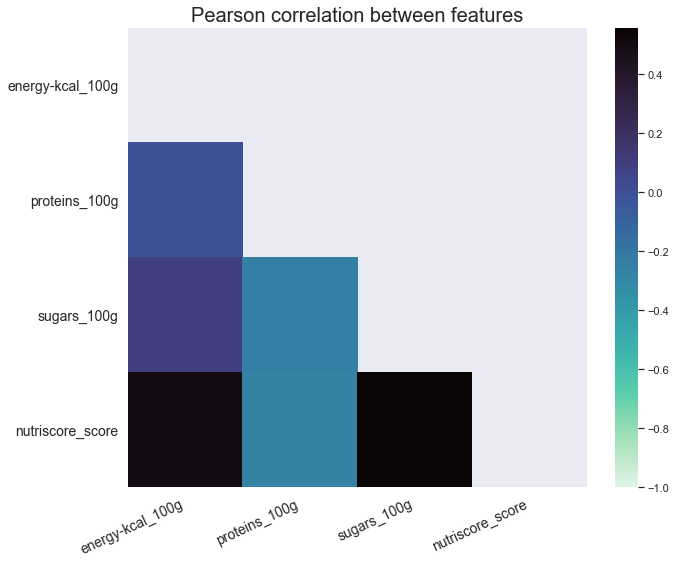

In [31]:
plt.figure(figsize=(10,8))
plt.title("Pearson correlation between features", size=20)

ax = sns.heatmap(df_correlation_matrix, mask=mask, vmin=-1, cmap="mako_r")

plt.xticks(rotation=25, size=14, horizontalalignment="right")
plt.yticks(rotation=0, size=14)
plt.tight_layout()
plt.savefig("img/pearson-correlation-between-features.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    
        <ul style="list-style-type: square;">
            <li><b>Energy-kcal_100g</b> has a strong direct relation with <b>nutriscore_score</b></li>
            <li><b>proteins_100g</b> has a weak relation with <b>sugars_100g</b> and <b>nutriscore_score</b></li>
            <li><b>sugars_100g</b> has a strong relation with <b>nutriscore_score</b></li>
            <li><b>proteins_100g</b> has an inverse relation with <b>nutriscore_score</b> and <b>sugars_100g</b></li>
        </ul>               
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6. Multivariate Analysis</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.1. Plotting Variables considering categories</h4>
</div>

<div class="alert alert-block alert-info">
    To make a <b>Multivariate Analysis</b>, we are going to <b>filter</b> the dataset only in <b>4 variables</b> and <b>3 categories</b>
</div>

In [32]:
df_multi_analysis = df_products[["renamed_category", "energy-kcal_100g", "proteins_100g", "sugars_100g", "nutriscore_score"]].copy()

In [33]:
df_multi_analysis = df_multi_analysis[df_multi_analysis["renamed_category"].isin(["Meats", "Dairy products", "Snacks"])]

In [34]:
df_multi_analysis.rename(columns = {"renamed_category":"category"}, inplace=True)

In [35]:
df_multi_analysis.head(3)

,category,energy-kcal_100g,proteins_100g,sugars_100g,nutriscore_score
0,Meats,197.000000,17.0,0.90000,4.000000
1,Meats,206.000000,16.0,1.70000,5.000000
2,Meats,151.921668,24.0,0.21262,3.666667


In [36]:
df_analysis(df_multi_analysis, "df_multi_analysis", "category", flag="complete")


Analysis of df_multi_analysis dataset
--------------------------------------------------------------------
- Dataset shape:                  10546 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  6911
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): category is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 494.3+ KB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,category,object,10546,3,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,energy-kcal_100g,float64,10546,856,0,0.0,260.438386,0.0,151.0,168.000000,418.0,593.0,148.594756
2,proteins_100g,float64,10546,415,0,0.0,20.044632,0.0,18.0,24.000000,24.0,44.0,7.206627
3,sugars_100g,float64,10546,515,0,0.0,5.270710,0.0,0.0,0.212620,1.0,62.0,11.390098
4,nutriscore_score,float64,10546,152,0,0.0,7.195281,-5.0,1.0,3.666667,13.0,34.0,8.189157


<div class="alert alert-block alert-info">
    Plotting the variables considering the categories
</div>

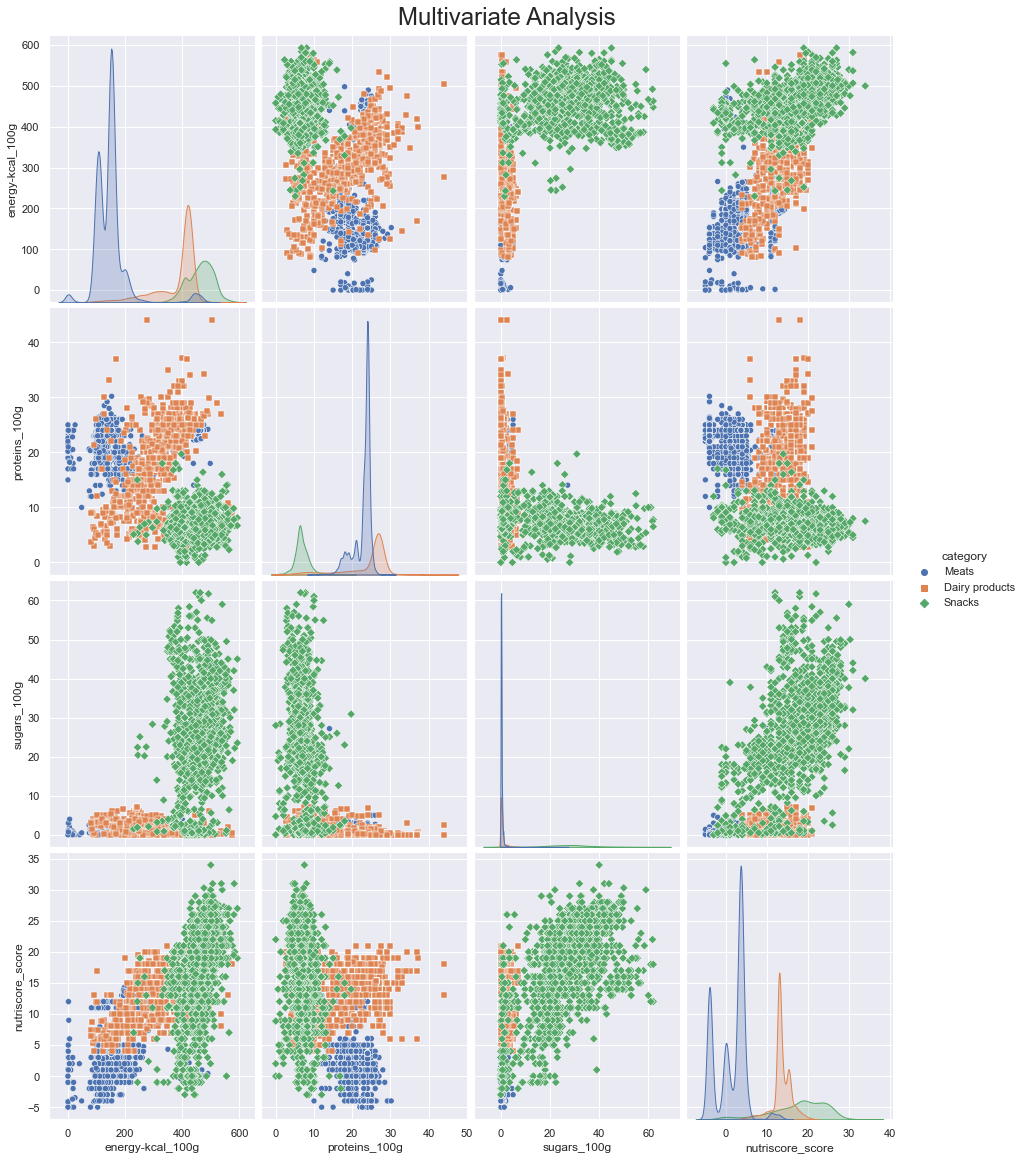

In [37]:
g = sns.pairplot(df_multi_analysis, hue="category", markers=["o", "s", "D"], height=4, aspect=0.8)
g.fig.suptitle("Multivariate Analysis", y=1.01 , size=24)
plt.savefig("img/correlation-categories-vs-variables.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    
        <ul style="list-style-type: square;">
            <li>Here, we can see mainly, the sugar influence in <b>nutriscore_score</b> and <b>Energy-kcal_100g</b></li>
            <ul style="list-style-type: disc;">
                 <li>In the <b>plot 9</b>, <b>sugar_100g</b> vs <b>energy-kcal_100g</b>, we can see the influence of the first one</li>
                <li>In the <b>plot 12</b>, <b>sugar_100g</b> vs <b>nutriscore_score</b>, we can see the influence of the first one as well</li>
            </ul>
        </ul>               
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.2. Correlation Matrix by Caterory</h4>
</div>

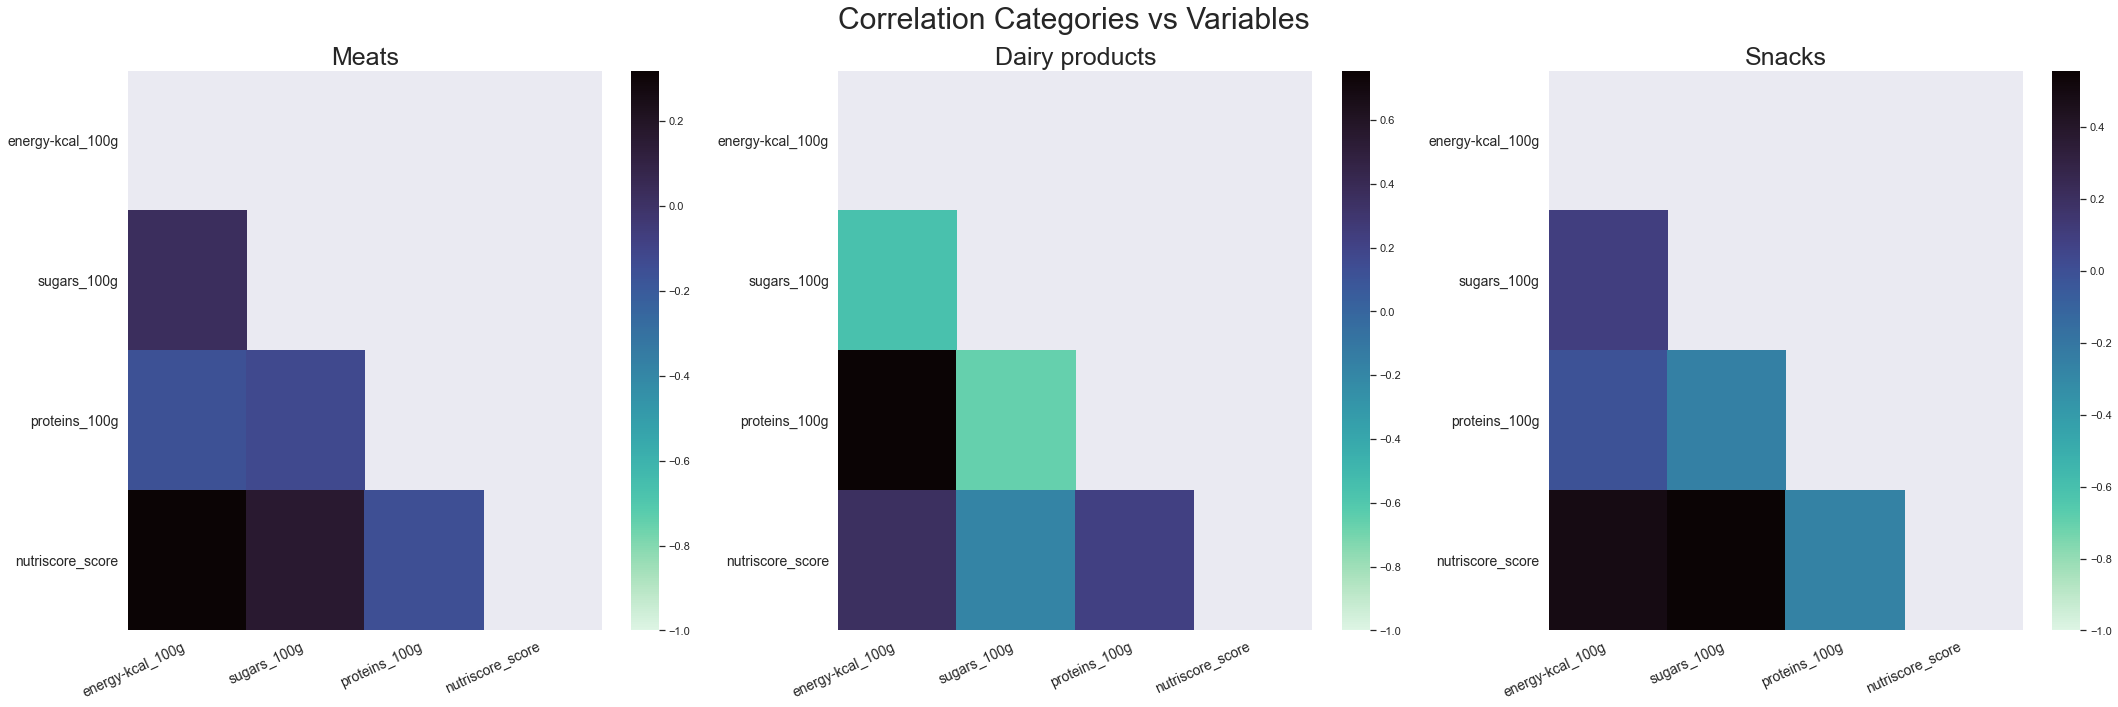

In [38]:
# Creating a figure composed of multiples matplotlib.Axes objects (ax_box and ax_hist)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[30,10])

plt.suptitle("Correlation Categories vs Variables", size=30)

VARIABLES_MULTI_ANALYSIS = ["energy-kcal_100g", "sugars_100g", "proteins_100g", "nutriscore_score"]

for category, ax in zip(df_multi_analysis["category"].unique(), axs.reshape(-1)):
    
    # Filtering the dataframe based on category
    df_temp = df_multi_analysis[df_multi_analysis["category"] == category][VARIABLES_MULTI_ANALYSIS]
    df_multi_analysis_correlation = pd.DataFrame(df_temp.corr())
    
    # Adding a mask not to show all blocks
    mask = np.zeros_like(df_multi_analysis_correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True 
    
    sns.heatmap(df_multi_analysis_correlation, mask=mask, vmin=-1, cmap="mako_r", ax=ax)
    
    ax.set_title(category, size=25)
    ax.set_xticklabels(VARIABLES_MULTI_ANALYSIS, rotation=25, size=14, horizontalalignment="right")
    ax.set_yticklabels(VARIABLES_MULTI_ANALYSIS, rotation=0, size=14)
    
plt.tight_layout()
plt.savefig("img/correlation-categories-vs-variables.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    
        <ul style="list-style-type: square;">
            <li><b>Energy-kcal_100g</b> has a strong direct relation with <b>nutriscore_score</b> in <b>all categories</b></li>
        </ul>               
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3. Correlation Matrix all Categories vs Variables</h4>
</div>

In [39]:
df_all_variables_multi_analysis = df_multi_analysis[VARIABLES_MULTI_ANALYSIS]

In [40]:
df_correlation_matrix = pd.DataFrame(df_all_variables_multi_analysis.corr())

In [41]:
df_correlation_matrix

,energy-kcal_100g,sugars_100g,proteins_100g,nutriscore_score
energy-kcal_100g,1.000000,0.593361,-0.456871,0.851840
sugars_100g,0.593361,1.000000,-0.817936,0.645705
proteins_100g,-0.456871,-0.817936,1.000000,-0.502973
nutriscore_score,0.851840,0.645705,-0.502973,1.000000


In [42]:
mask = np.zeros_like(df_correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True 

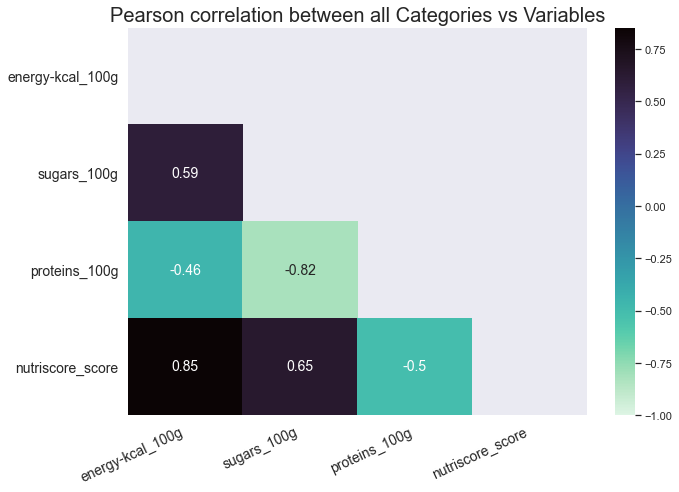

In [43]:
plt.figure(figsize=(10,7))
plt.title("Pearson correlation between all Categories vs Variables", size=20)

ax = sns.heatmap(df_correlation_matrix, mask=mask, vmin=-1, cmap="mako_r",
                annot=True, annot_kws={"size": 14})

plt.xticks(rotation=25, size=14, horizontalalignment="right")
plt.yticks(rotation=0, size=14)
plt.tight_layout()
plt.savefig("img/pearson-correlation-between-features.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>    
        <ul style="list-style-type: square;">
            <li><b>Energy-kcal_100g</b> and <b>sugars_100g</b> have a strong direct relation with <b>nutriscore_score</b></li>
        </ul>               
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.3. Principal component analysis - PCA</h4>
</div>

<div class="alert alert-block alert-info">
    To limit the analysis to be performed, we are going to work considering the following:
    <ul style="list-style-type: square;">
        <li>All variables in the dataset, excluding "Nutri-Score"</li>
        <li>Only the category <b>Snacks</b></li>
    </ul>
</div>

In [44]:
df_pca_sample = df_products[(df_products["renamed_category"]=="Snacks") & (df_products["nutriscore_grade"].notnull())].copy()

In [45]:
df_pca_sample_variables = df_pca_sample[[col for col in df_products.columns if df_products[col].dtype == "float64" and col != "nutriscore_score" ]].copy()

In [46]:
df_pca_sample_variables.head(5)

,energy-kcal_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g
10735,528.000000,32.099998,46.900002,14.9,20.700001,10.7,0.65
10736,464.216277,13.300000,70.199997,7.0,35.700001,6.1,0.83
10737,452.000000,19.400000,62.599998,9.8,44.599998,5.5,0.25
10738,514.000000,28.100000,58.599998,16.4,35.099998,5.5,0.90
10739,565.000000,39.000000,42.000000,23.0,40.000000,7.8,0.10


In [47]:
df_pca_sample_variables.shape

(1758, 7)

<div class="alert alert-block alert-info">
   Numbers of components to calculate to PCA            
</div>

In [48]:
n_comp = 6

<div class="alert alert-block alert-info">
   Transforming dataframe into numpy array and keep the columns index and name        
</div>

In [49]:
X = df_pca_sample_variables.values
index_values = df_pca_sample_variables.index
features = df_pca_sample_variables.columns

<div class="alert alert-block alert-info">
   Data standardization      
</div>

In [50]:
X_scaled = StandardScaler().fit_transform(X)

<div class="alert alert-block alert-info">
   Principal components determination      
</div>

In [51]:
pca = PCA(n_components=n_comp).fit(X_scaled)

<div class="alert alert-block alert-info">
   Principal components determination      
</div>

In [52]:
df_pca = pd.DataFrame(pca.components_, 
                      index=["PC" + str(i+1) for i in range(n_comp)],
                      columns=features ).T

In [53]:
df_pca.shape

(7, 6)

<div class="alert alert-block alert-info">
   Principal components determination      
</div>

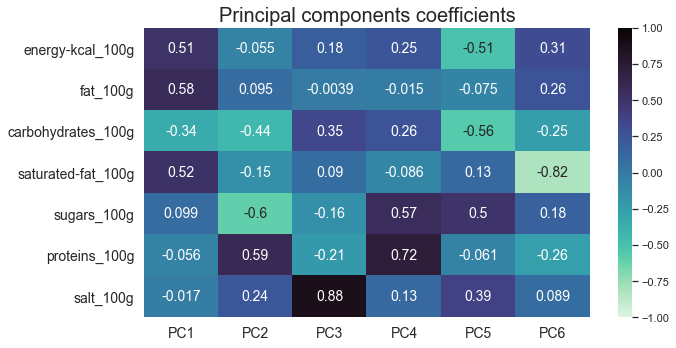

In [54]:
plt.figure(figsize=(10,5))
plt.title("Principal components coefficients", size=20)

ax = sns.heatmap(df_pca, vmin=-1, vmax=1, center=0, cmap="mako_r",
                annot=True, annot_kws={"size": 14})

plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()
plt.savefig("img/principal-components-coefficients.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br>
    In this graph we have the influence of each of the variables for each component
    <ul style="list-style-type: square;">
        <li><b>salt_100g</b> has a strong influence in <b>PC3</b></li>
        <li><b>PC1</b> has a influence by <b>energy-kcal_100g</b>, <b>fat_100g</b> and <b>saturated-fat_100g</b>. Probably this principal components includes <b>snacks</b></li>
    </ul>     
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Scree of eigenvalues</b>
</div>

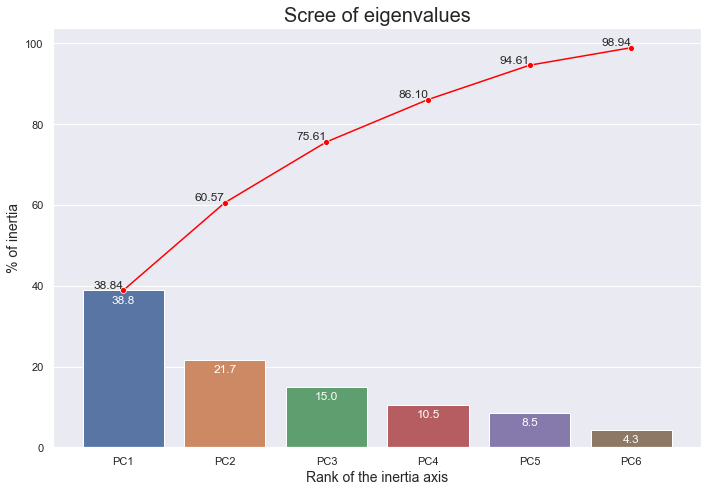

In [55]:
scree = pca.explained_variance_ratio_*100

fig = plt.subplots(figsize=(10, 7))
plot_bar = sns.barplot(x=df_pca.columns, y=scree)
for p in plot_bar.patches:
    plot_bar.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="bottom", xytext=(0, -15), textcoords="offset points", color="white")
plot_line = sns.lineplot(x=df_pca.columns, y=scree.cumsum(), marker="o", color="red")

for x, y in zip(df_pca.columns, scree.cumsum()):
    plot_line.text(x, y, "{:.2f}".format(y), ha="right", va="bottom")

plt.xlabel("Rank of the inertia axis", size=14)
plt.ylabel("% of inertia", size=14)
plt.title("Scree of eigenvalues", size=20)
plt.tight_layout()
plt.savefig("img/scree-of-eigenvalues.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    
    <ul style="list-style-type: square;">
        <li>Up to <b>PC3</b>, we describe <b>75%</b> of the variance of the data</li>
        <li>Up to <b>PC2</b>, we describe <b>60%</b> of the variance of the data. It means that the <b>first and seconds principal component are most relevants</b></li>
    </ul>     
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation Circle</b>
</div>

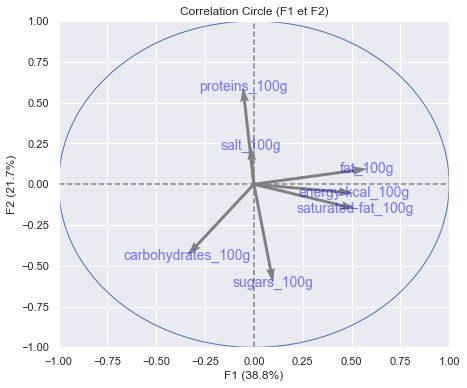

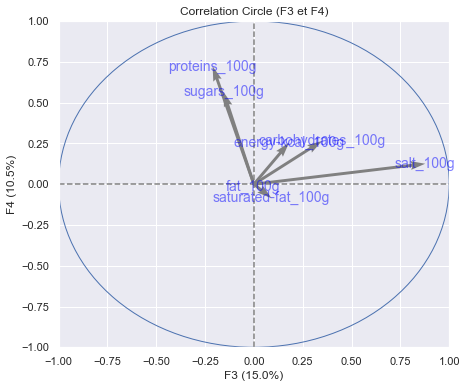

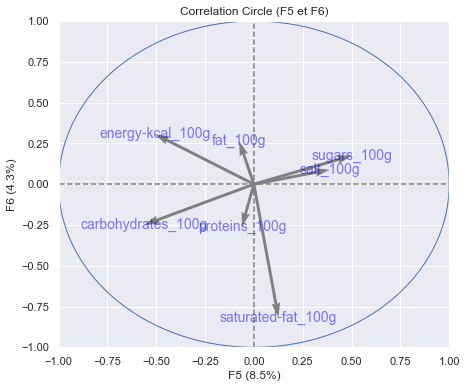

In [56]:
display_circles(pca.components_, n_comp, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    <ul style="list-style-type: square;">
        <li><b>F1</b> and <b>F2</b></li>
            <ul style="list-style-type: disc;">
               <li><b>energy-kcal_100g</b>, <b>fat_100g</b> and <b>saturated-fat_100g</b> have a strong correlation with <b>F1</b></li>
               <li><b>proteins_100g</b> has a strong correlation with <b>F2</b></li>
               <li><b>carbohydrates_100g</b> and <b>sugar_100g</b>have a negative correlation with <b>F2</b></li>
        </ul>
        <li><b>F3</b> and <b>F4</b></li>
            <ul style="list-style-type: disc;">
               <li><b>salt_100g</b> has a strong correlation with <b>F3</b></li>
               <li><b>proteins_100g</b> and <b>sugar_100g</b>have a negative correlation with <b>F4</b></li>
            </ul>
        <li><b>F5</b> and <b>F6</b></li>
            <ul style="list-style-type: disc;">
               <li><b>saturated-fat_100g</b> has a negative correlation with <b>F6</b></li>
               <li><b>carbohydrates_100g</b> and <b>energy-kcal_100g</b>have a negative correlation with <b>F5</b></li>
               <li><b>sugar_100g</b> has a strong correlation with <b>F5</b></li>
            </ul>
    </ul>     
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Projection of individuals</b>
</div>

In [57]:
X_projected = pca.transform(X_scaled)
index_values_sample = pd.Series(index_values).sample(100)

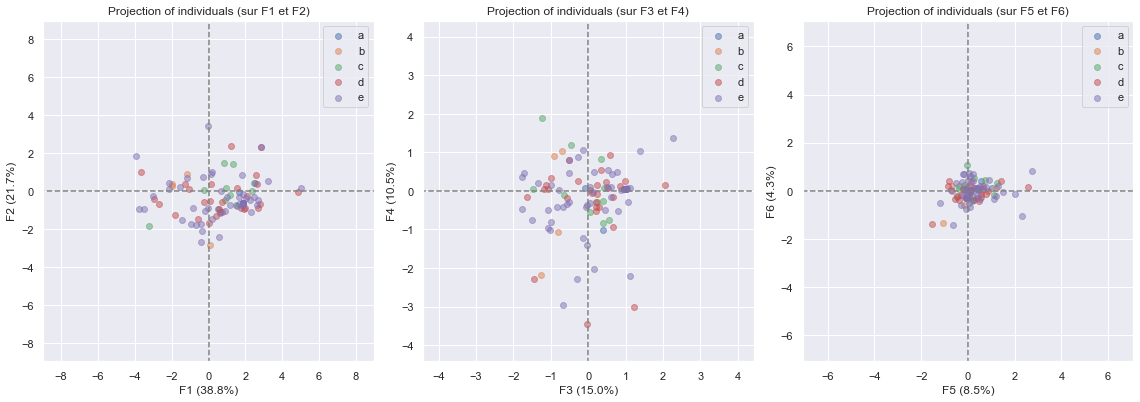

In [58]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], 
                         labels=np.array(index_values_sample), illus_var=df_pca_sample.loc[index_values_sample, "nutriscore_grade"], 
                         lab_on=False, alpha = 0.5)

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br><br>
    Here, we can see in details, the correlation of <b>nutriscore_grade</b> based on its variables
    <ul style="list-style-type: square;">
        <li><b>F1</b> and <b>F2</b></li>
            <ul style="list-style-type: disc;">
               <li><b>energy-kcal_100g</b>, <b>fat_100g</b> and <b>saturated-fat_100g</b> have a strong correlation with <b>F1</b></li>
               <li><b>proteins_100g</b> has a strong correlation with <b>F2</b></li>
               <li><b>carbohydrates_100g</b> and <b>sugar_100g</b>have a negative correlation with <b>F2</b></li>
        </ul>
        <li><b>F3</b> and <b>F4</b></li>
            <ul style="list-style-type: disc;">
               <li><b>salt_100g</b> has a strong correlation with <b>F3</b></li>
               <li><b>proteins_100g</b> and <b>sugar_100g</b>have a negative correlation with <b>F4</b></li>
            </ul>
        <li><b>F5</b> and <b>F6</b></li>
            <ul style="list-style-type: disc;">
               <li><b>saturated-fat_100g</b> has a negative correlation with <b>F6</b></li>
               <li><b>carbohydrates_100g</b> and <b>energy-kcal_100g</b> have a negative correlation with <b>F5</b></li>
               <li><b>sugar_100g</b> has a strong correlation with <b>F5</b></li>
            </ul>
    </ul>     
</div>